## Problem statement

You are helping out Unicorn Investors with your data hacking skills. They are considering making an investment in a new form of transportation - JetRail. JetRail uses Jet propulsion technology to run rails and move people at a high speed! While JetRail has mastered the technology and they hold the patent for their product, the investment would only make sense, if they can get more than 1 Million monthly users with in next 18 months.

You need to help Unicorn ventures with the decision. They usually invest in B2C start-ups less than 4 years old looking for pre-series A funding. In order to help Unicorn Ventures in their decision, you need to forecast the traffic on JetRail for the next 7 months. You are provided with traffic data of JetRail since inception in the test file.

## Hypothesis Generation

1. Increase in passenger traffic with passing years (population has upward trend with time)
2. High traffic between may to october (tourist season)
3. More traffic on weekdays than weekends
4. High traffic during peak hours

## Understand the data 

In [1]:
# import necessary libraries

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas import Series
%matplotlib inline
import warnings
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm

In [2]:
# read the test and train data

train = pd.read_csv(r"..\data\Train_SU63ISt.csv")
test = pd.read_csv(r"..\data\Test_0qrQsBZ.csv")

# copy of test and train data

train_original = pd.read_csv(r"..\data\Train_SU63ISt.csv")
test_original = pd.read_csv(r"..\data\Test_0qrQsBZ.csv")

In [3]:
# dataset structure and content

train.columns, test.columns

(Index(['ID', 'Datetime', 'Count'], dtype='object'),
 Index(['ID', 'Datetime'], dtype='object'))

In [4]:
# data-types of each feature

train.dtypes, test.dtypes

(ID           int64
 Datetime    object
 Count        int64
 dtype: object, ID           int64
 Datetime    object
 dtype: object)

In [5]:
# shape of the data set

train.shape, test.shape

((18288, 3), (5112, 2))

## Exploration and Pre-processing

In [6]:
# change the 'Datetime' column data type from object to datetime 

train["Datetime"] = pd.to_datetime(train["Datetime"], format = "%d-%m-%Y %H:%M")
test["Datetime"] = pd.to_datetime(test["Datetime"], format = "%d-%m-%Y %H:%M")
train_original["Datetime"] = pd.to_datetime(train_original["Datetime"], format = "%d-%m-%Y %H:%M")
test_original["Datetime"] = pd.to_datetime(test_original["Datetime"], format = "%d-%m-%Y %H:%M")

In [7]:
# check the effect of hour, day, month and year on passenger traffic 

for i in (train,train_original,test,test_original):
    i['year'] = i.Datetime.dt.year
    i['month'] = i.Datetime.dt.month
    i['day'] = i.Datetime.dt.day
    i['hour'] = i.Datetime.dt.hour

In [8]:
# check the effect of weekday and weekend on passenger traffic 

# find day of week

train["day_of_week"] = train["Datetime"].dt.dayofweek
temp = train["Datetime"]

# assign weekday(0) or weekend(1)

def applyr(row):
    if row.dayofweek == 5 or row.dayofweek == 6:  # 0-4:weekdays ; 5-6:weekends
        return 1
    else:
        return 0
    
temp2 = train["Datetime"].apply(applyr)
train["weekend"] = temp2

C:\Users\Sayandeep Ghosh\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


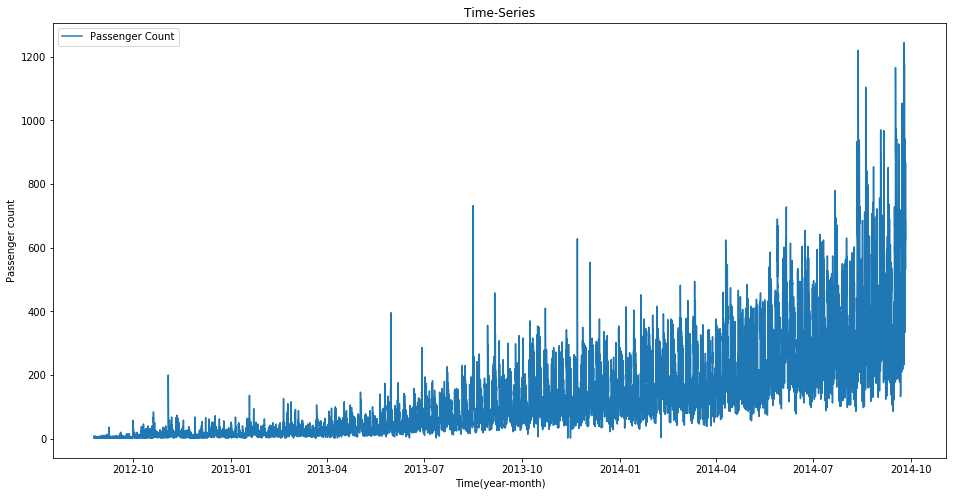

In [9]:
# visualise the time series

train.index = train["Datetime"]
df = train.drop("ID",1)
ts = df["Count"]

plt.figure(figsize=(16,8))
plt.plot(ts, label='Passenger Count')
plt.title("Time-Series")
plt.xlabel("Time(year-month)")
plt.ylabel("Passenger count")
plt.legend(loc='best')

Increasing trend in traffic over time. 

Occasional spike in count. 

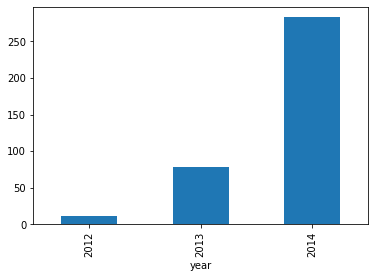

In [10]:
# check the trend in traffic over years (hypothesis 1)

train.groupby("year")["Count"].mean().plot.bar()

Rising trend in traffic over years.

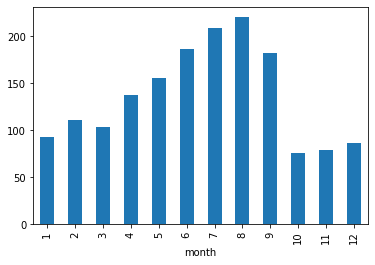

In [11]:
# check for increase in traffic between may to october (hypothesis 2)

train.groupby("month")["Count"].mean().plot.bar()

Decrease in mean passenger count in last three months.

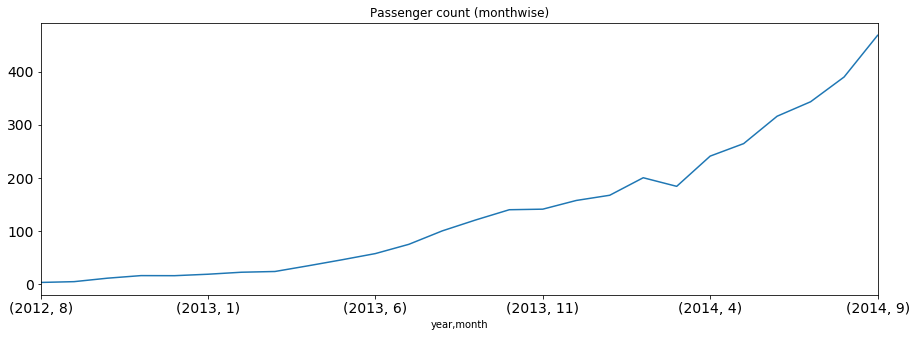

In [12]:
# check monthly mean of each year separately

temp = train.groupby(["year","month"])["Count"].mean()
temp.plot(figsize=(15,5), title='Passenger count (monthwise)', fontsize=14)

Notice that 10, 11, 12 months are absent in 2014 and thier value in 2012 is very less and hence the drop in mean values for these months.

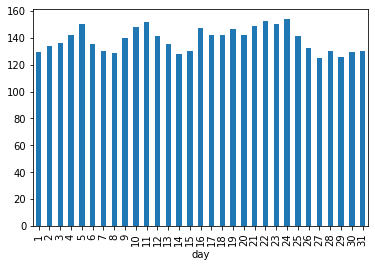

In [13]:
# check the daily passenger count

train.groupby("day")["Count"].mean().plot.bar()


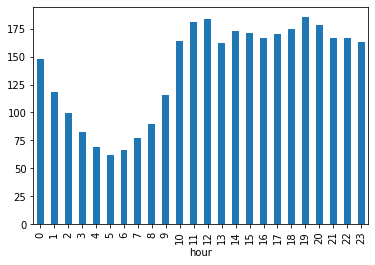

In [14]:
# check the hourly passenger count (hypothesis 4)

train.groupby("hour")["Count"].mean().plot.bar()

Notice the passenger traffic to identify the peak and non-peak hours of the day.

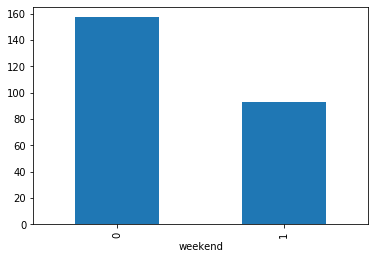

In [15]:
# check the trend based on weekdays(0) and weekends(1) (hypothesis 3)

train.groupby("weekend")["Count"].mean().plot.bar()

More traffic on weekdays than weekends.

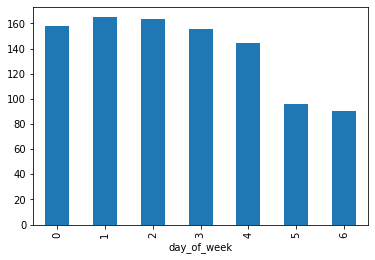

In [16]:
# check the trend on the day of week (0-6:mon-sun)

train.groupby("day_of_week")["Count"].mean().plot.bar()

In [17]:
# drop 'ID' variable

train = train.drop("ID",1)

In [18]:
# aggregating the hourly time series to daily, weekly and monthly time series to reduce noise and increase stability; and make it easier for a model to learn.

train.Timestamp = pd.to_datetime(train["Datetime"], format = "%d-%m-%Y %H:%M")
train.index = train.Timestamp

# hourly time series
hourly = train.resample('H').mean()

# converting to daily mean
daily = train.resample('D').mean()

# converting to weekly mean
weekly = train.resample('W').mean()

# converting to daily mean
monthly = train.resample('M').mean()


C:\Users\Sayandeep Ghosh\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until


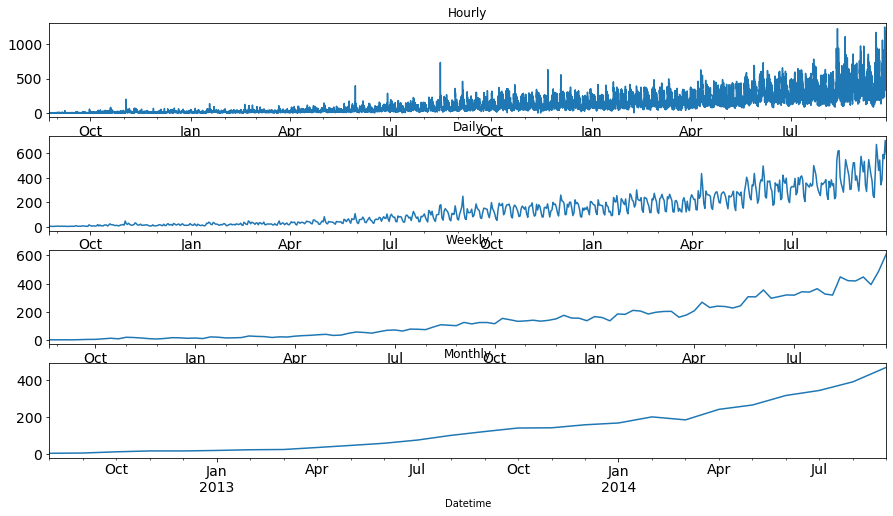

In [19]:
# visualise the aggregated time series

fig, axs = plt.subplots(4,1)
hourly.Count.plot(figsize=(15,8), title="Hourly", fontsize=14, ax=axs[0])
daily.Count.plot(figsize=(15,8), title="Daily", fontsize=14, ax=axs[1])
weekly.Count.plot(figsize=(15,8), title="Weekly", fontsize=14, ax=axs[2])
monthly.Count.plot(figsize=(15,8), title="Monthly", fontsize=14, ax=axs[3])

plt.show()

Note that time series becomes more atable as we aggregate it on daily, weekly, monthly basis.

In [20]:
# working on daily time series

# test data

test.Timestamp = pd.to_datetime(test["Datetime"], format = "%d-%m-%Y %H:%M")
test.index = test.Timestamp

# converting to daily mean
test = test.resample('D').mean()

# train data

train.Timestamp = pd.to_datetime(train["Datetime"], format = "%d-%m-%Y %H:%M")
train.index = train.Timestamp

# converting to daily mean
train = train.resample('D').mean()

C:\Users\Sayandeep Ghosh\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """


## Modelling and Evaluation

In [21]:
# splitting the data into training and validation sets
# taking the last 3 months data as validation data and rest as train data (avoid random split - timeseries data)

Train = train.ix['2012-08-15':'2014-06-24']
valid = train.ix['2014-06-25':'2014-09-25']

C:\Users\Sayandeep Ghosh\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
C:\Users\Sayandeep Ghosh\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


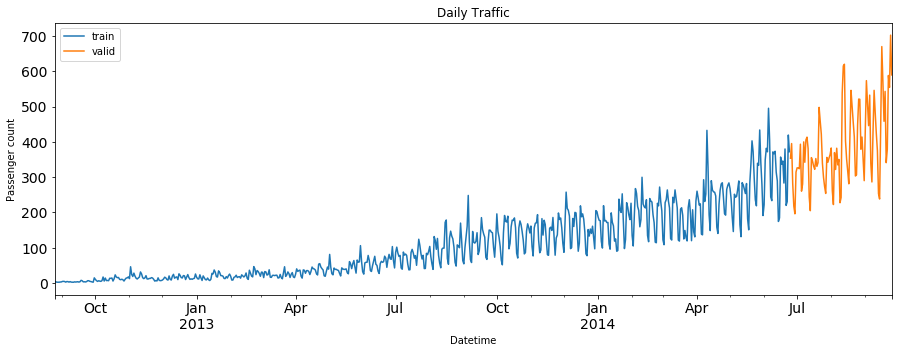

In [22]:
# visualise the train and valid data

Train.Count.plot(figsize=(15,5), title='Daily Traffic', fontsize=14, label='train')
valid.Count.plot(figsize=(15,5), title='Daily Traffic', fontsize=14, label='valid')
plt.xlabel('Datetime')
plt.ylabel('Passenger count')
plt.legend(loc='best')
plt.show()

### Naive Approach

Next expected point is equal to last observed point.

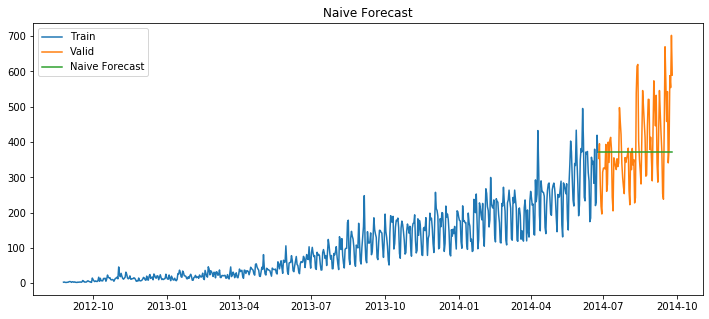

In [23]:
dd = np.asarray(Train.Count)
y_hat = valid.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(12,5))
plt.plot(Train.index, Train['Count'], label='Train')
plt.plot(valid.index, valid['Count'], label='Valid')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title('Naive Forecast')
plt.show()

In [24]:
# RMSE evaluation

rmse = sqrt(mean_squared_error(valid.Count,y_hat.naive))
print(rmse)

111.79050467496724


### Moving Average

Takes average of passenger counts for last few time periods

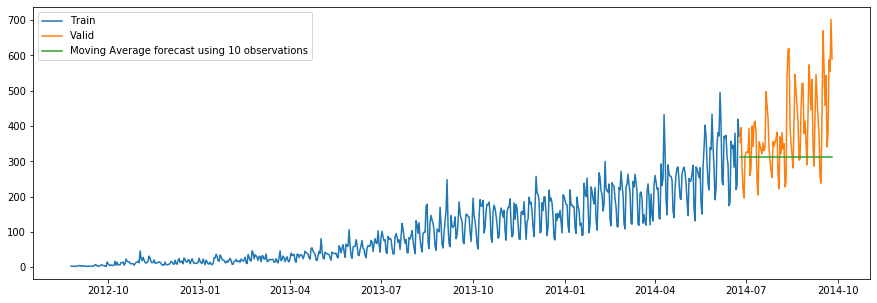

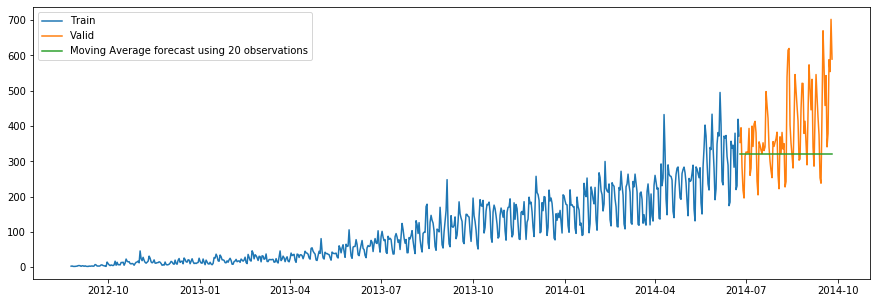

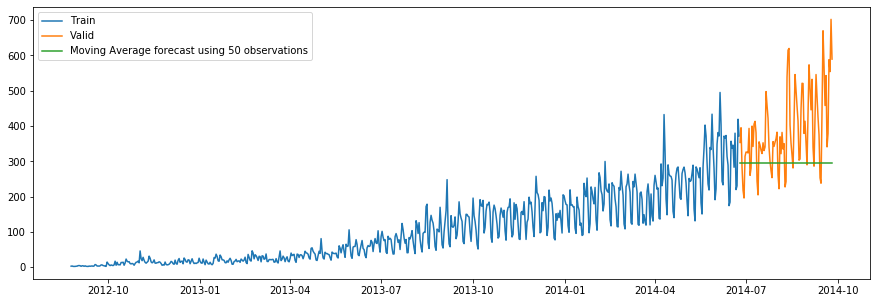

In [25]:
for i in [10,20,50]:
    y_hat_avg = valid.copy()
    y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(i).mean().iloc[-1]
    plt.figure(figsize=(15,5))
    plt.plot(Train['Count'], label='Train')
    plt.plot(valid['Count'], label='Valid')
    plt.plot(y_hat_avg['moving_avg_forecast'], label = 'Moving Average forecast using {} observations'.format(i))
    plt.legend(loc='best')
    plt.show()

In [26]:
# RMSE evaluation

rmse = sqrt(mean_squared_error(valid.Count,y_hat_avg.moving_avg_forecast))
print(rmse)

144.19175679986802


### Simple Exponential Smoothing

Assign larger weights to more recent observations than observations from distant past. Weights decrease exponentially, smallest weights are associated with oldest observations.

Note: Naive approach is a simple exponential smooting with entire weight being assigned to the last last observed value.

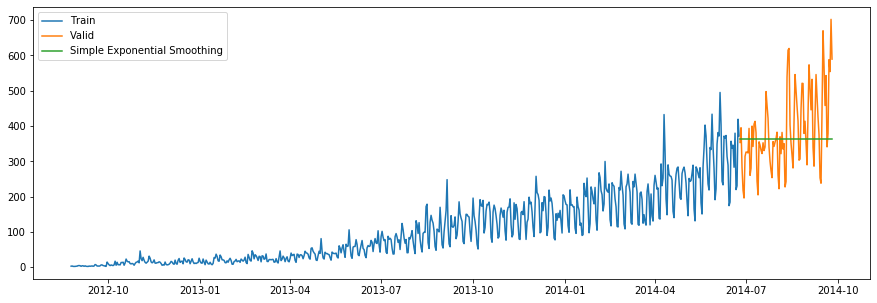

In [27]:
y_hat_avg = valid.copy()
fit2 = SimpleExpSmoothing(np.asarray(Train['Count'])).fit(smoothing_level=0.6, optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(valid))
plt.figure(figsize=(15,5))
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['SES'], label = 'Simple Exponential Smoothing')
plt.legend(loc='best')
plt.show()

In [28]:
# RMSE evaluation

rmse = sqrt(mean_squared_error(valid.Count,y_hat_avg.SES))
print(rmse)

113.43708111884514


### Holt's Linear Trend model

Extension of SES model to allow forecasting of data with a trend. The forecast function in this model is a function of level and trend.

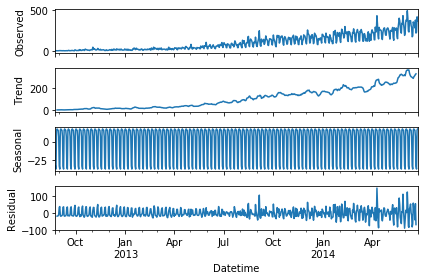

In [29]:
# visualising the trend (inc/dec), seasonality & error (or residual obtained after removing the trend or seasonality in data)

sm.tsa.seasonal_decompose(Train.Count).plot()
result = sm.tsa.stattools.adfuller(train.Count)
plt.show()

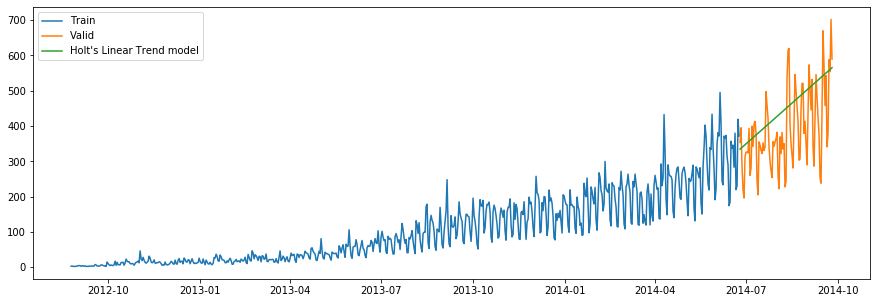

In [30]:
# build a model based on the observed increasing trend

y_hat_avg = valid.copy()
fit1 = Holt(np.asarray(Train['Count'])).fit(smoothing_level=0.3, smoothing_slope=0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(valid))
plt.figure(figsize=(15,5))
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['Holt_linear'], label = "Holt's Linear Trend model")
plt.legend(loc='best')
plt.show()

In [31]:
# RMSE evaluation

rmse = sqrt(mean_squared_error(valid.Count,y_hat_avg.Holt_linear))
print(rmse)

112.94278345314041


### Holt's Linear Trend Model on daily time series

We make predictions on daily time series and then distribute that daily predictions into hourly predictions.

In [32]:
# load submission file

submission = pd.read_csv(r"..\data\sample_submission_LSeus50.csv")

# make prediction for the test dataset

predict = fit1.forecast(len(test))

# save prediction in new column

test['prediction'] = predict

Convert daily predictions to hourly basis. First, calculate the passenger count for each hour of everyday. Then fine average ratio of passenger count for every hour of 24 hours. To calculate hourly prediction, multiply the daily prediction with hourly ratio.

In [33]:
# calculating the hourly ratio of count
train_original['ratio']=train_original['Count']/train_original['Count'].sum()

# grouping by hourly ratio
temp = train_original.groupby(['hour'])['ratio'].sum()

# groupby to csv format
pd.DataFrame(temp,columns=["hour","ratio"]).to_csv(r'..\data\GROUPby.csv')

temp2 = pd.read_csv(r'..\data\GROUPby.csv')
temp2 = temp2.drop("hour.1",1)

# merge test and test_original on day, month and year
merge = pd.merge(test,test_original, on=('day','month','year'), how='left')
merge['hour'] = merge['hour_y']
merge = merge.drop(['year','month', 'Datetime', 'hour_x', 'hour_y'], axis=1)

# predicting by merging merge and temp2
prediction=pd.merge(merge, temp2, on='hour', how='left')

# converting the ratio to the original scale
prediction['Count'] = prediction['prediction']*prediction['ratio']*24
prediction['ID']=prediction['ID_y']

# keep ID and Count only and drop other features
submission = prediction.drop(['ID_x', 'ID_y', 'day', 'prediction', 'hour', 'ratio'], axis=1)

# converting the submission to csv format
pd.DataFrame(submission,columns=['ID','Count']).to_csv('Holt_linear.csv')

### Holt Winter's Trend Model on daily time series

Takes into account the seasonality(pattern repeats after fixed intervals). Seasonality could not be predicted from earlier models. Holt Winter's method apply exponential smoothing to the seasonal components, but could not on the trend component.

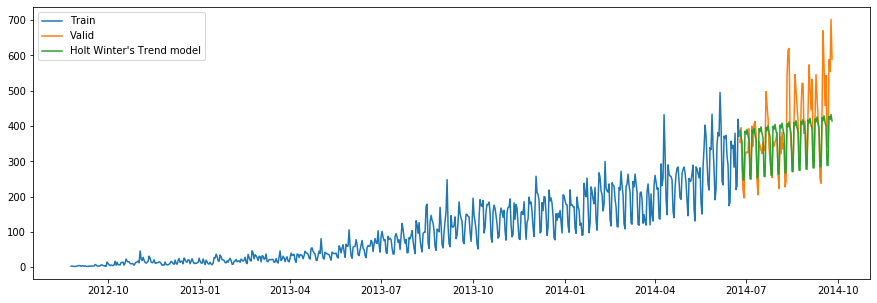

In [34]:
# build a model based on the observed increasing trend and seasonality

y_hat_avg = valid.copy()
fit1 = ExponentialSmoothing(np.asarray(Train['Count']), seasonal_periods=7, trend='add', seasonal='add').fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(valid))
plt.figure(figsize=(15,5))
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['Holt_Winter'], label = "Holt Winter's Trend model")
plt.legend(loc='best')
plt.show()

In [35]:
# RMSE evaluation

rmse = sqrt(mean_squared_error(valid.Count,y_hat_avg.Holt_Winter))
print(rmse)

82.37571191747172


In [36]:
# forecast count for entire test dataset                                                        

predict = fit1.forecast(len(test))

Converting daily ratio count to hourly ratio count as earlier.

In [37]:
# save prediction in new column
test['prediction'] = predict

# merge test and test_original on day, month and year
merge = pd.merge(test,test_original, on=('day','month','year'), how='left')
merge['hour'] = merge['hour_y']
merge = merge.drop(['year','month', 'Datetime', 'hour_x', 'hour_y'], axis=1)

# predicting by merging merge and temp2
prediction=pd.merge(merge, temp2, on='hour', how='left')

# converting the ratio to the original scale
prediction['Count'] = prediction['prediction']*prediction['ratio']*24
prediction['ID']=prediction['ID_y']

# keep ID and Count only and drop other features
submission = prediction.drop(['ID_x', 'ID_y', 'day', 'prediction', 'hour', 'ratio'], axis=1)

# converting the submission to csv format
pd.DataFrame(submission,columns=['ID','Count']).to_csv('Holt_Winter.csv')

### ARIMA Model

Stationarity check -> Dickey Fuller Test (determines how strongly a time-series is defined by its trend)

Null hypothesis: Time series is not stationary | Alternate hypothesis: Time series is stationary

If 'test statistic' is less than the 'critical value', we reject null hypothesis, i.e., series is stationary.

In [38]:
# make a function to calculate the results of Dickey Fuller test

from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    # determining rolling statistics
    rolmean = timeseries.rolling(24).mean() # 24 hours on each day
    rolstd = timeseries.rolling(24).std()
    
    # plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # perform Dickey Fuller test
    print('Results of Dickey Fuller test:')
    dftest = adfuller(timeseries,autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key]=value
    print(dfoutput)
    

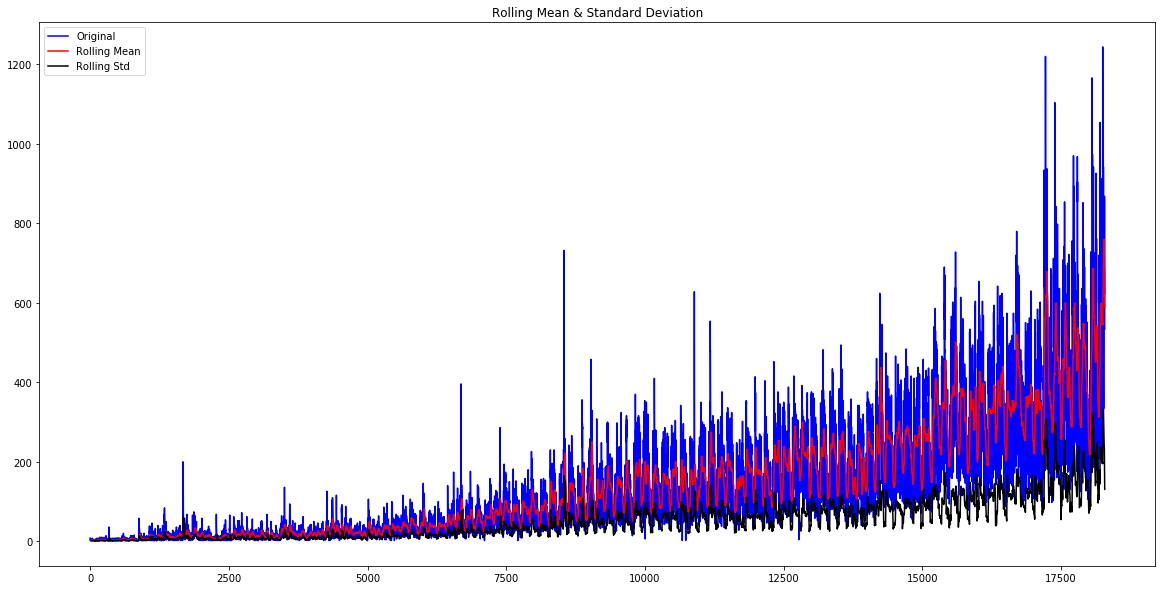

Results of Dickey Fuller test:
Test Statistic                    -4.456561
p-value                            0.000235
#Lags Used                        45.000000
Number of Observations Used    18242.000000
Critical Value (1%)               -3.430709
Critical Value (5%)               -2.861698
Critical Value (10%)              -2.566854
dtype: float64


In [39]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10

test_stationarity(train_original['Count'])

Test Statistic < Critical Value

Reject Null Hypothesis,i.e., time-series stationary.

But, we see increasing trend in time series. So, we need to make the time series data more stationary by removing tend and seasonality.

Removing trend: The data shows an increasing trend. So we can apply transformation that penalises higher values more than lower ones, like log transformation

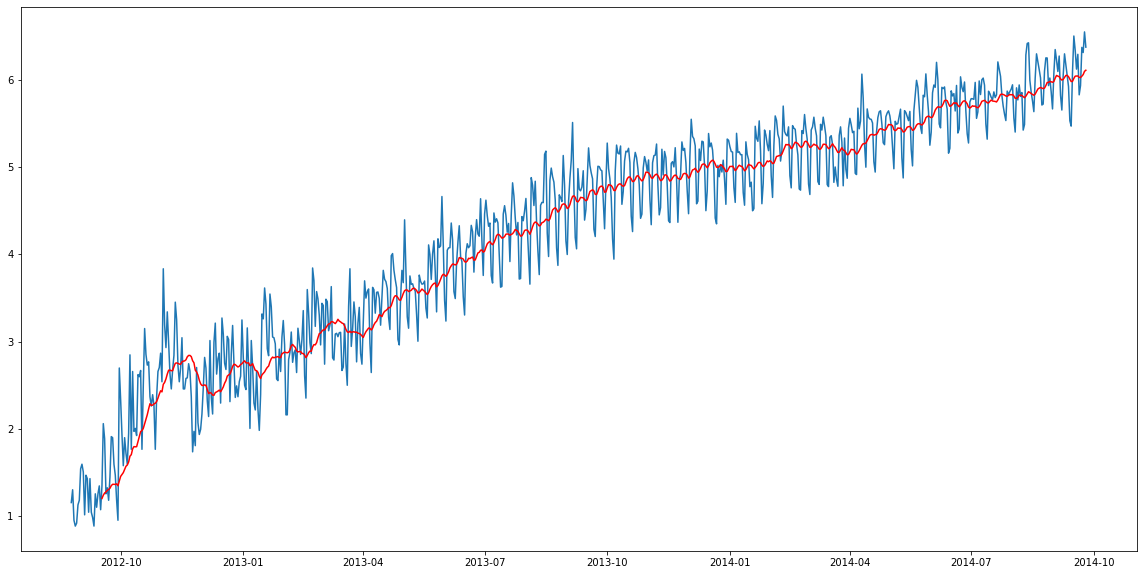

In [40]:
# take rolling average to remove trend with a window of 24 hours

train_log = np.log(train['Count'])
valid_log = np.log(valid['Count'])

moving_avg = train_log.rolling(24).mean()
plt.plot(train_log)
plt.plot(moving_avg,color='red')
plt.show()


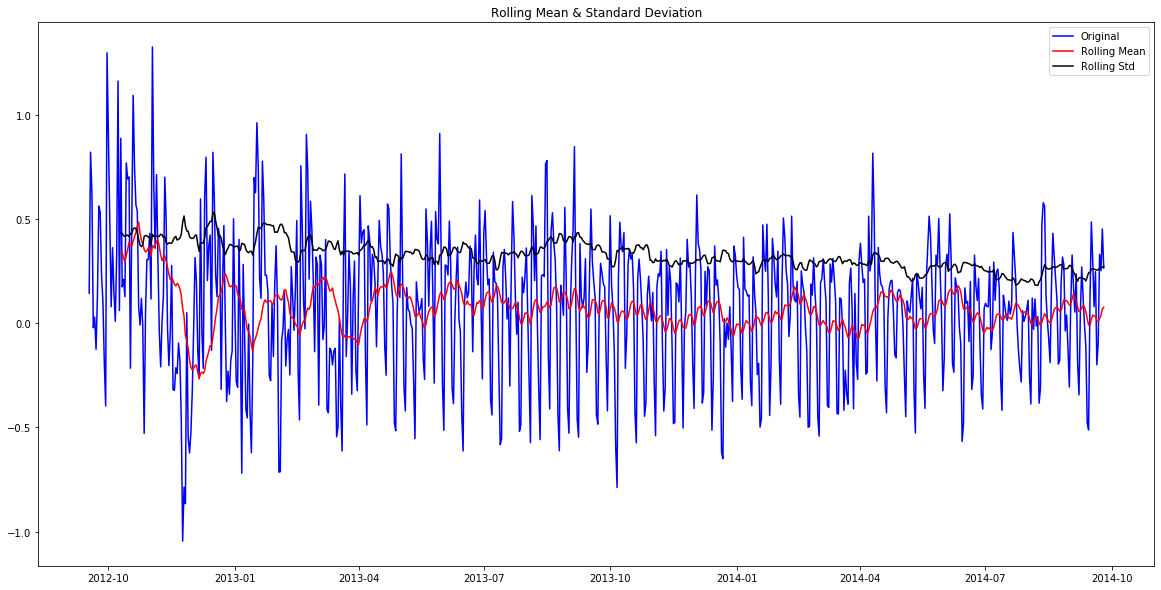

Results of Dickey Fuller test:
Test Statistic                -6.294458e+00
p-value                        3.533739e-08
#Lags Used                     2.000000e+01
Number of Observations Used    7.180000e+02
Critical Value (1%)           -3.439490e+00
Critical Value (5%)           -2.865574e+00
Critical Value (10%)          -2.568918e+00
dtype: float64


In [41]:
# remove the increasing trend to make time series stationary

train_log_moving_avg_diff = train_log-moving_avg

# since we took avg of 24 values, rolling mean is not defined for the first 23 values. so, let's drop the null values.

train_log_moving_avg_diff.dropna(inplace=True)

# test stationarity now
test_stationarity(train_log_moving_avg_diff)

Test Statistic is very small compared to Critical value. So we may say that the trend is removed. 

Let's now stabilise the mean of the time series to make it stationary. Differencing helps to make the time series stable and eliminate the trend.


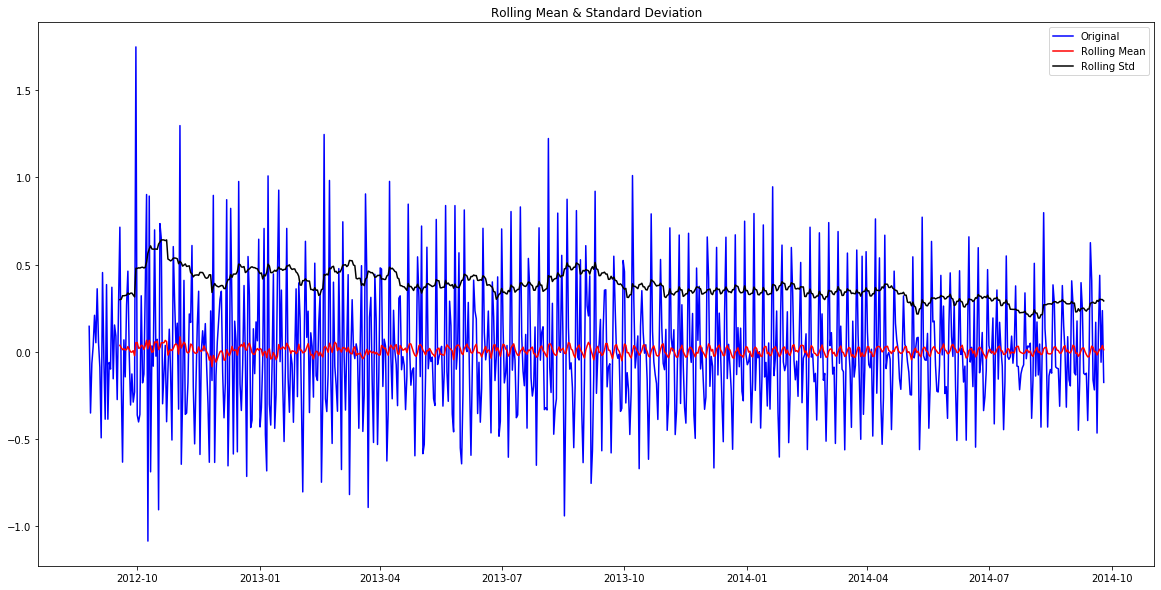

Results of Dickey Fuller test:
Test Statistic                -8.877418e+00
p-value                        1.346196e-14
#Lags Used                     1.900000e+01
Number of Observations Used    7.410000e+02
Critical Value (1%)           -3.439206e+00
Critical Value (5%)           -2.865448e+00
Critical Value (10%)          -2.568851e+00
dtype: float64


In [42]:
train_log_diff = train_log - train_log.shift(1)

test_stationarity(train_log_diff.dropna())

Removing Seasonality(priodic fluctuations): Seasonality occurs for a fixed or known period. We use seasonal decompose to decompose to decompose the time series into trend, seasonality and residuals.

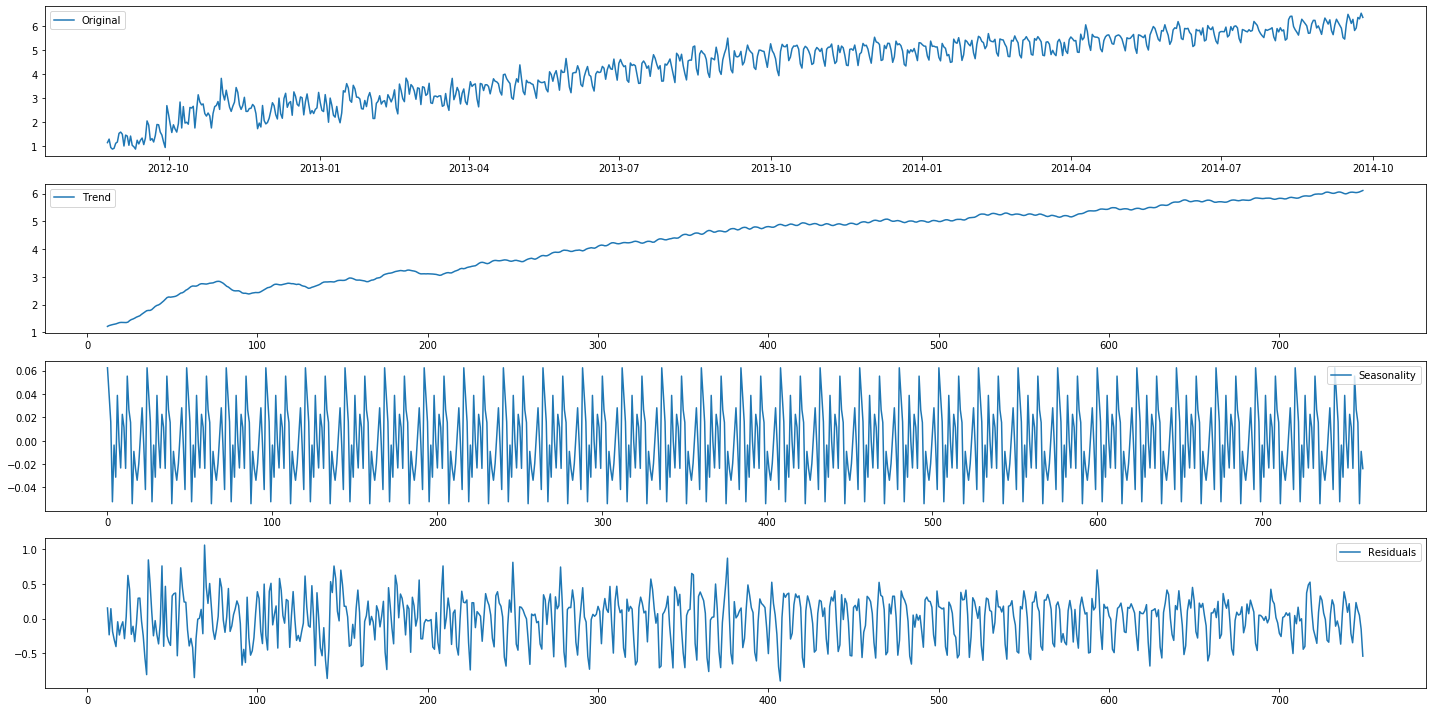

In [46]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(pd.DataFrame(train_log).Count.values, freq=24)

trend = decompose.trend
seasonal = decompose.seasonal
residual = decompose.resid

plt.subplot(411)
plt.plot(train_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Note, the repetetion in pattern for seasonality.

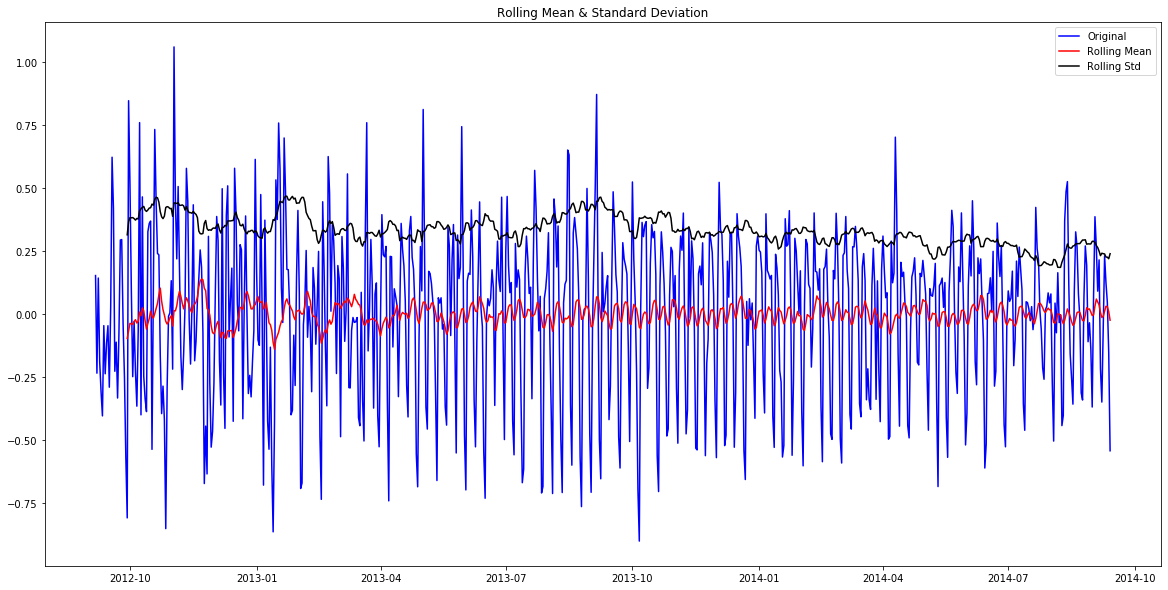

Results of Dickey Fuller test:
Test Statistic                -8.418146e+00
p-value                        2.017347e-13
#Lags Used                     2.000000e+01
Number of Observations Used    7.170000e+02
Critical Value (1%)           -3.439503e+00
Critical Value (5%)           -2.865579e+00
Critical Value (10%)          -2.568921e+00
dtype: float64


In [47]:
# checking for stationarity of residuals

train_log_decompose = pd.DataFrame(residual)
train_log_decompose['date'] = train_log.index
train_log_decompose.set_index('date',inplace=True)
train_log_decompose.dropna(inplace=True)
test_stationarity(train_log_decompose[0])

We can interpret that residuals are stationary. (p-value < 0.05, reject null hypothesis for non-stationarity)

Now we fit ARIMA model to our time series data. For that we need optimized values for:

p: order of auto-regresssive model (number of time lags) -> AR

d: degree of differencing (number of times the data has past values substracted) -> I

q: order of moving average model -> MA

For that we use ACF and PACF.

ACF(Auto Corelation Function): Correlation of time  series with a lagged version of itself, i.e., x(t) with x(t-1), x(t-2)... x(t-n-1) for n th lag. This is to find the lag for MA series(q).

PACF(Partial Auto Correlation Function): Correlation of time  series with a lagged version of itself after eliminating the variations. 